# Analyse exact solutions of the QUBO for the departure delay only model for various penalty weights #

In [15]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import polynomial
import yaml
import h5py
import matplotlib.lines
import matplotlib.backends.backend_pdf

In [16]:
%matplotlib inline

## Helper function to plot single validity map and validity boundary ##

In [17]:
def plotValidityMap(ax, title, validityMap, validityBoundary):
    ax.set_xlabel('Penalty Weight Conflict')
    ax.set_ylabel('Penalty Weight Unique')
    ax.set_xlim(0, 2.1)
    ax.set_ylim(0, 2.1)
    minenergy = validityMap['energy'].values.min()
    maxenergy = validityMap['energy'].values.max()
    invalid = validityMap[validityMap['isValid'] == False]
    sizes = [(100 - 30) * (e - minenergy) / maxenergy + 30 for e in invalid.energy.values]
    ax.scatter(invalid['penalty-weight-conflict'], invalid['penalty-weight-unique'], c='r', linewidth=0, s=sizes)
    valid = validityMap[validityMap['isValid'] == True]
    sizes = [(100 - 30) * (e - minenergy) / maxenergy + 30 for e in valid.energy.values]
    ax.scatter(valid['penalty-weight-conflict'], valid['penalty-weight-unique'], c='g', linewidth=0, s=sizes)
    ax.plot(validityBoundary['penalty-weight-conflict'], validityBoundary['penalty-weight-unique'], marker='o', linestyle='--', markersize=5, c='k')
    ax.set_title(title)
    labels = []
    labels.append(matplotlib.lines.Line2D([], [], color='g', marker='o', markersize=8, linewidth=0, label='valid'))
    labels.append(matplotlib.lines.Line2D([], [], color='r', marker='o', markersize=8, linewidth=0, label='invalid'))
    labels.append(matplotlib.lines.Line2D([], [], color='w', marker='o', markersize=10, linewidth=1, label='energy = %0.3f' % maxenergy))
    labels.append(matplotlib.lines.Line2D([], [], color='w', marker='o', markersize=2, linewidth=1, label='energy = %0.3f' % minenergy))
    labels.append(matplotlib.lines.Line2D([], [], color='k', linestyle='--', marker='o', markersize=5, label='Validity Boundary'))

    ax.legend(handles=labels, loc='best');

## Get validity maps and validity boundaries ##

In [18]:
pmin = 0
pmax = 48
delaySteps = [3, 6, 9]
maxDelay = 18
validityMaps = {}
validityBoundaries = {}
numFlights = {}
numConflicts = {}
partitions = []
for partition in range(pmin, pmax + 1):
    for delayStep in delaySteps:
        resultfile = '../data/connectedComponents/maxDelayPrecalc018/results/atm_instance_partition%04i_delayStep%03i_maxDelay%03i.results.h5' % (partition, delayStep, maxDelay)
        f = h5py.File(resultfile, 'r')
        if 'validityMap' in f and 'validityBoundary' in f:
            f.close()
            partitions.append(partition)
            validityMap = pd.read_hdf(resultfile, key='validityMap')
            energies = []
            for pw2, pw3 in zip(validityMap['penalty-weight-unique'].values.tolist(), validityMap['penalty-weight-conflict'].values.tolist()):
                f = h5py.File(resultfile, 'r')
                g = f['pw-unique%0.3f-conflict%0.3f' % (pw2, pw3)]
                sg = g['exactSolution']
                energy = sg['energy'].value 
                f.close()
                energies.append(energy)
            validityMap['energy'] = energies
            validityMaps[(partition, delayStep)] = validityMap
            
            f = h5py.File(resultfile, 'r')
            validityBoundary = f['validityBoundary'].value
            f.close()
            validityBoundaries[(partition, delayStep)] = validityBoundary
            
            # get number of flights and conflicts
            instancefile = '../../../../precalculation/data/instances/connectedComponents/maxDepartDelayPrecalculation_018/atm_instance_partition%04i_delayStep%03i_maxDelay%03i.h5' % (partition, delayStep, maxDelay)
            f = h5py.File(instancefile, 'r')
            numFlights[partition] = f['atm-instance'].attrs['Number of flights']
            numConflicts[partition] = f['atm-instance'].attrs['Number of conflicts']
            f.close()

        else:
            f.close()
            

partitions = sorted(list(set(partitions)))

## Plot and save to multipage PDF file ##

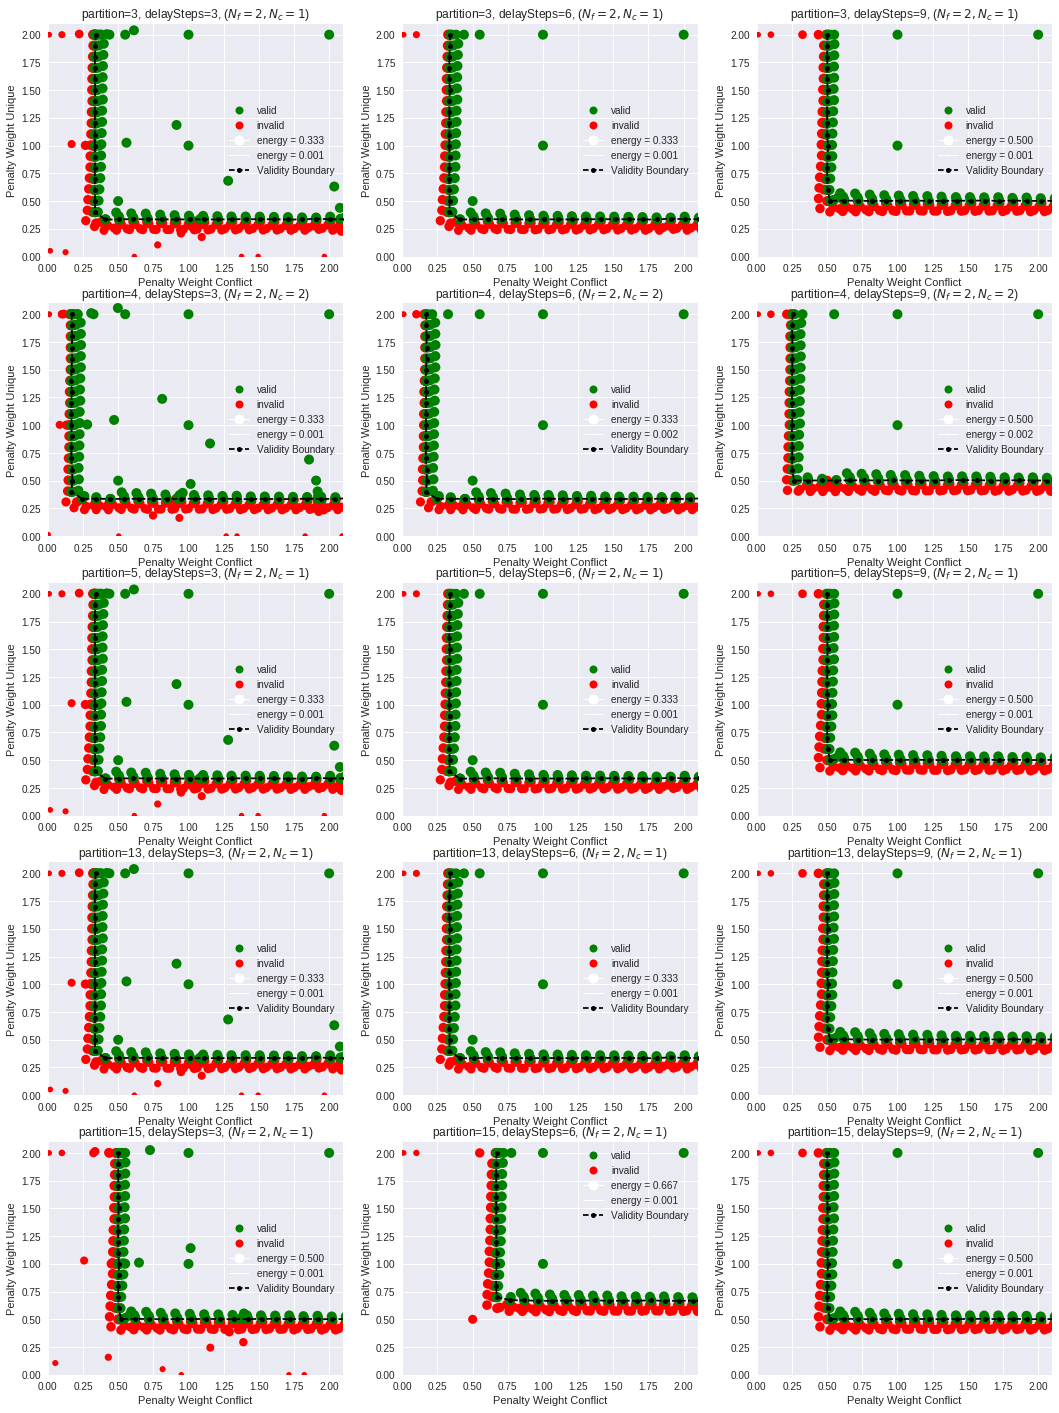

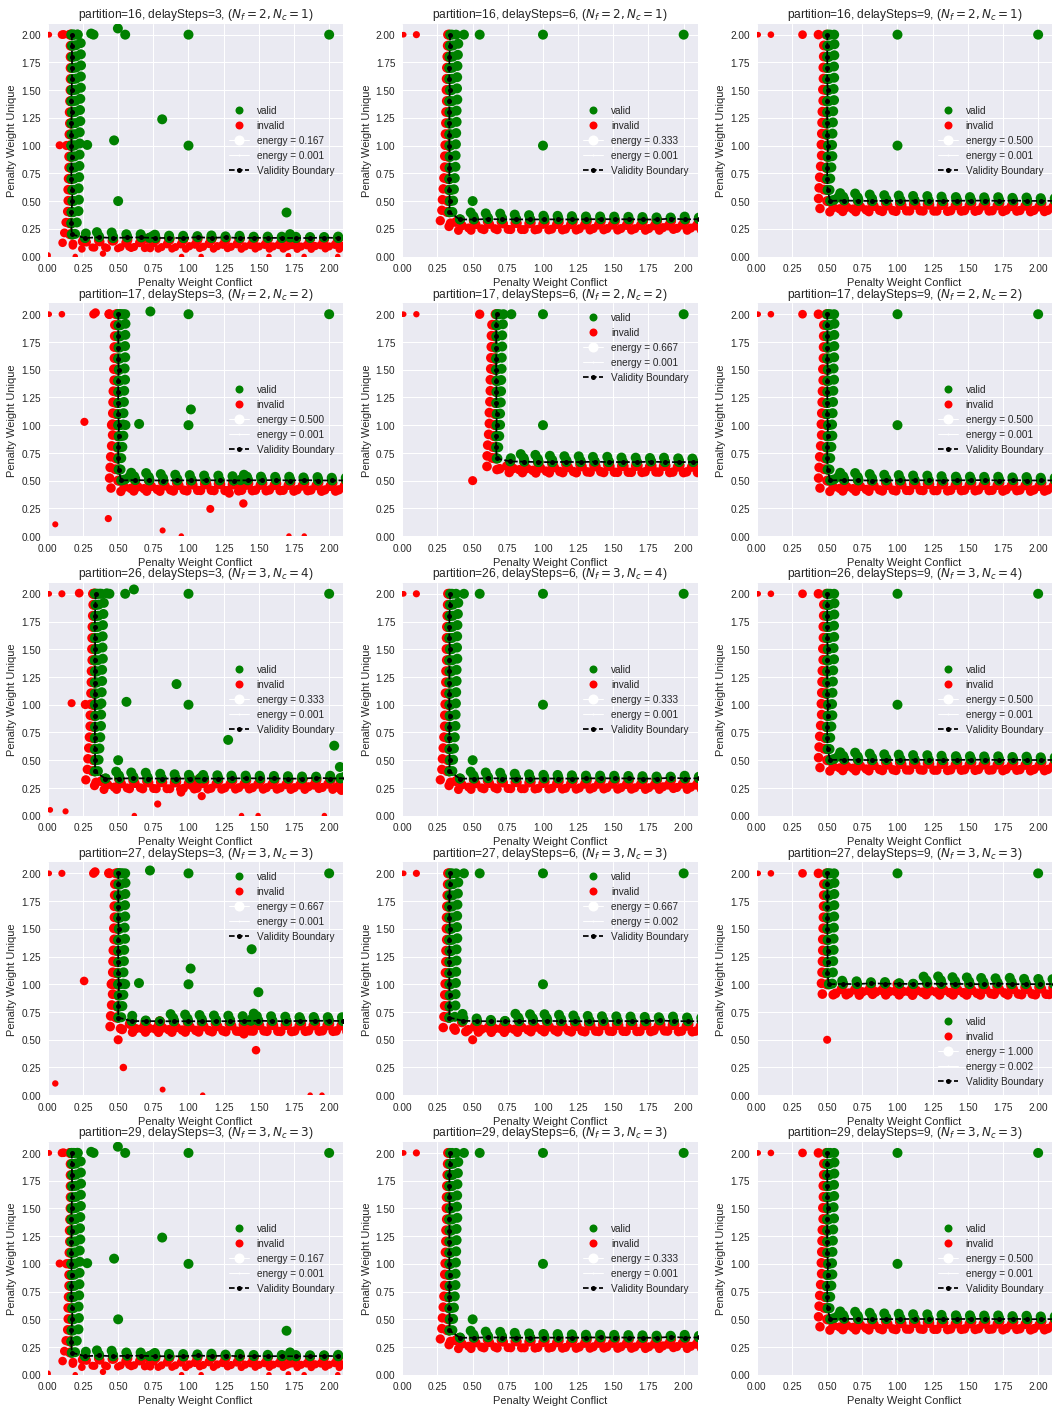

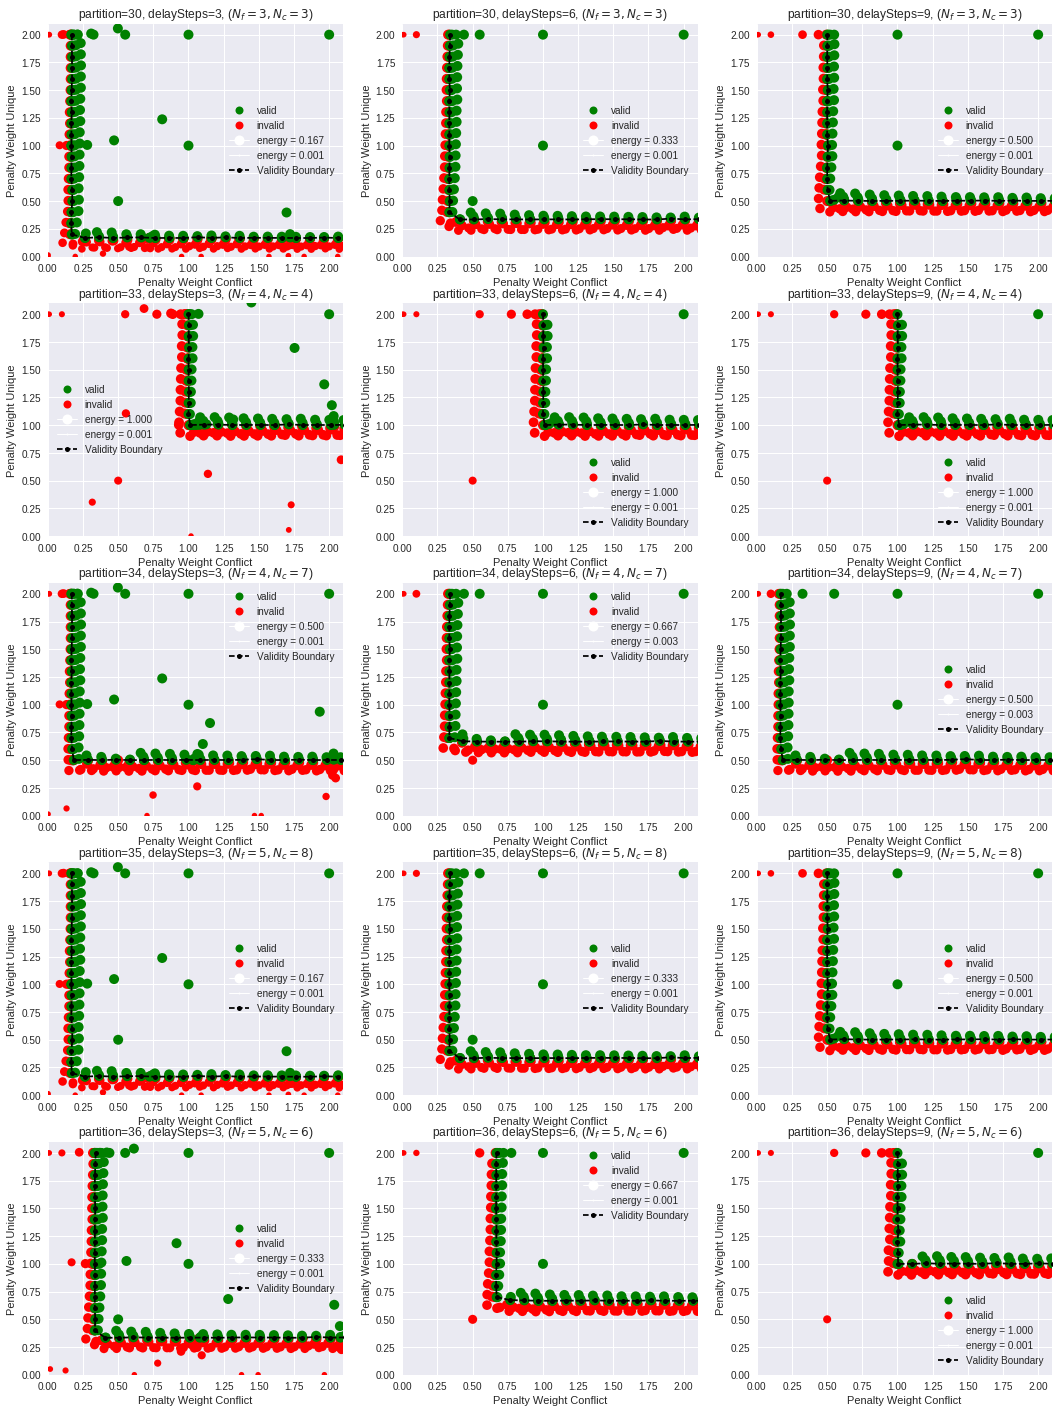

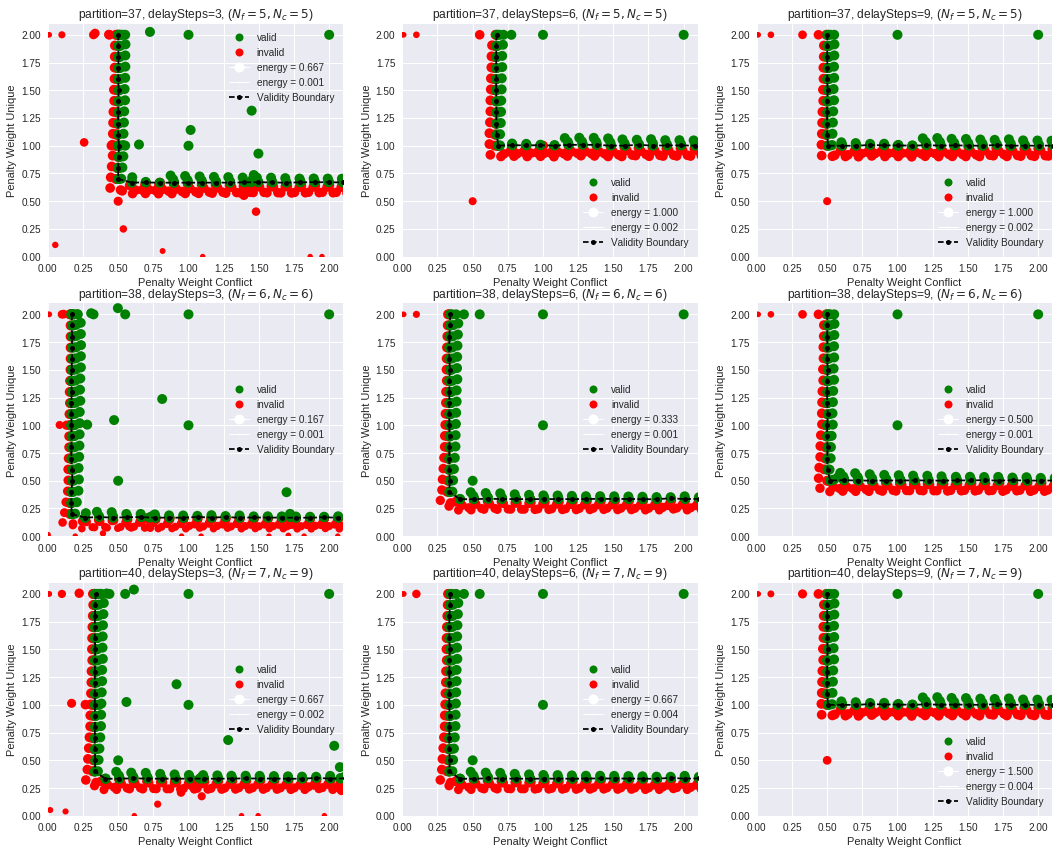

In [19]:
nperpage = 5

Npart = len(partitions)
Ndelay = len(delaySteps)
pdf = matplotlib.backends.backend_pdf.PdfPages('validity_maps.pdf');
for n in range(Npart):
    if n % nperpage == 0:
        fig = plt.figure(figsize=(6 * Ndelay, 6 * nperpage));

    for i in range(Ndelay):
        ax = fig.add_subplot(nperpage + 1, Ndelay, n % nperpage * Ndelay + i + 1)
        p = partitions[n]
        d = delaySteps[i]
        f = numFlights[p]
        c = numConflicts[p]
        plotValidityMap(ax, 'partition=%i, delaySteps=%i, ($N_f=%i, N_c=%i$)' % (p, d, f, c), validityMaps[(p, d)], validityBoundaries[(p, d)])    
    if n % nperpage == nperpage - 1 or n == Npart - 1:
        pdf.attach_note('Validity Maps for the Departure Only Model');
        pdf.savefig(figure=fig);
pdf.close();

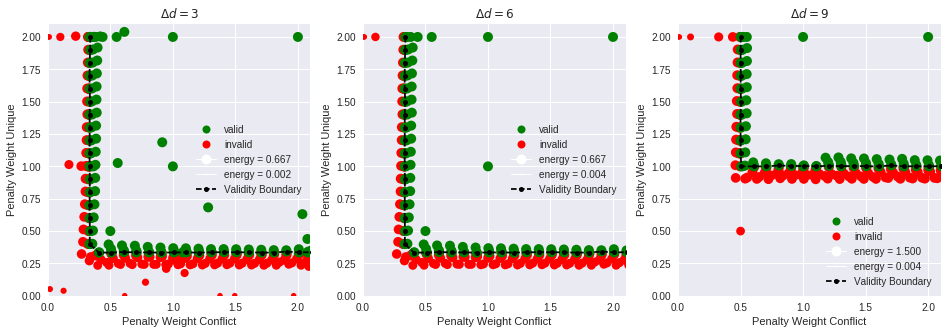

In [20]:
pdf = matplotlib.backends.backend_pdf.PdfPages('validity_maps_examples.pdf');
fig = plt.figure(figsize=(16, 5));

n = partitions.index(40)
for i in range(Ndelay):
    ax = fig.add_subplot(1, Ndelay, i + 1)
    p = partitions[n]
    d = delaySteps[i]
    f = numFlights[p]
    c = numConflicts[p]
    plotValidityMap(ax, '$\Delta d=%i$' % d, validityMaps[(p, d)], validityBoundaries[(p, d)])    

pdf.savefig(figure=fig);
pdf.close();

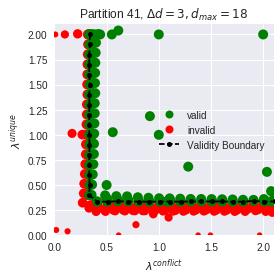

In [21]:
import seaborn
pdf = matplotlib.backends.backend_pdf.PdfPages('validity_maps_examples_2.pdf');
fig = plt.figure(figsize=(4, 4));

n = partitions.index(40)
for i in [0]:
    ax = fig.add_subplot(1, 1, 1)
    p = partitions[n]
    d = delaySteps[i]
    f = numFlights[p]
    c = numConflicts[p]
    plotValidityMap(ax, '$\Delta d=%i$' % d, validityMaps[(p, d)], validityBoundaries[(p, d)])    
    ax.set_xlabel('$\lambda^{conflict}}$')
    ax.set_ylabel('$\lambda^{unique}}$')
    ax.set_title('Partition 41, $\Delta d =3, d_{max} = 18$')
    labels = []
    labels.append(matplotlib.lines.Line2D([], [], color='g', marker='o', markersize=8, linewidth=0, label='valid'))
    labels.append(matplotlib.lines.Line2D([], [], color='r', marker='o', markersize=8, linewidth=0, label='invalid'))
    labels.append(matplotlib.lines.Line2D([], [], color='k', linestyle='--', marker='o', markersize=5, label='Validity Boundary'))

    ax.legend(handles=labels, loc='best');
plt.tight_layout()
pdf.savefig(figure=fig)
pdf.close();